In [1]:
import time

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import sys
import errno

from common.camera import *
from common.visualization import *
from common.utils import *
from common.generators import ChunkedGenerator, UnchunkedGenerator
from common.h36m_dataset import Human36mDataset, preprocess_Human36m
from common.visualization import *
from common.model import *
from common.xianhui_dataset import *
import matplotlib
import glob
import plotly
import json
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

from scripts.build_model import *
from scripts.train import *
from scripts.eval import *
from scripts.data_preprocessing_cmu_mocap import *

In [2]:
data_root_path = "../wild_data_cmu/output_human/" 

In [3]:
dataset, keypoints = load_and_preprocess_cmu_mocap(data_root_path)

 load 3d data 
 processing 3d data 
 load 2d keypoints 
 processing 2d keypoints 


In [4]:
subjects = sorted(dataset.subjects())
subjects_train = subjects[:1]
subjects_semi = subjects[15:23]
subjects_test = subjects[:10]

In [5]:
cameras_valid, poses_valid, poses_valid_2d = fetch(dataset = dataset,
                                                   keypoints = keypoints, 
                                                   subjects = subjects_test, 
                                                   stride = 1)

cameras_train, poses_train, poses_train_2d = fetch(dataset = dataset,
                                                   keypoints = keypoints, 
                                                   subjects = subjects_train, 
                                                   stride = 1)

cameras_semi, _, poses_semi_2d = fetch(dataset = dataset,
                                       keypoints = keypoints,
                                       subjects = subjects_semi,
                                       stride = 1)

In [6]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [7]:
resume = True
filter_widths = [3,3,3,3,3]
model_pos_train, model_pos, model_traj, model_traj_train = build_models(17, 2, 17, filter_widths)

# chk_filename = "../checkpoint/pretrained_h36m_cpn.bin"
chk_filename = "checkpoints/epoch_80.bin"
print('Loading checkpoint', chk_filename)
checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)
print('This model was trained for {} epochs'.format(checkpoint['epoch']))
model_pos_train.load_state_dict(checkpoint['model_pos'])
model_pos.load_state_dict(checkpoint['model_pos'])
model_traj_train.load_state_dict(checkpoint['model_traj'])
model_traj.load_state_dict(checkpoint['model_traj'])

Loading checkpoint checkpoints/epoch_80.bin
This model was trained for 80 epochs


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
receptive_field = model_pos.receptive_field()
print('INFO: Receptive field: {} frames'.format(receptive_field))
pad = (receptive_field - 1) // 2 # Padding on each side

INFO: Receptive field: 243 frames


In [9]:
batch_size = 10240
train_generator = ChunkedGenerator(batch_size, cameras_train, poses_train, poses_train_2d, 1, pad=pad, causal_shift=0, shuffle=True, augment=False)

In [10]:
test_generator = UnchunkedGenerator(cameras_valid[:1], 
                                    poses_valid[:1], 
                                    poses_valid_2d[:1], 
                                    pad=pad, 
                                    causal_shift=0, 
                                    augment=False)

In [11]:
# def camera2screen_self(input_3d_cam, cam, w=640, h=480):
#     batch_size, nframe, njoints, nchannel = inputs_3d.shape
#     input_3d_cam_total = input_3d_cam.reshape(batch_size, nframe * njoints, nchannel)
#     cam = cam.reshape(batch_size, 3, 3).transpose(1,2)
#     # projection
#     proj_2d_screen = torch.matmul(input_3d_cam_total, cam)
#     proj_2d_screen[:,:,0] /= proj_2d_screen[:,:,2]
#     proj_2d_screen[:,:,1] /= proj_2d_screen[:,:,2]
#     proj_2d_screen = proj_2d_screen[:,:,:2].reshape(batch_size, nframe, njoints, 2)
#     # normalization
#     return normalize_screen_coordinates(proj_2d_screen[..., :2], w=w, h=h)

In [12]:
dists = []
for cam, batch, batch_2d in test_generator.next_epoch():
    inputs_3d = torch.from_numpy(batch.astype('float32'))
    inputs_2d = torch.from_numpy(batch_2d.astype('float32'))
    cam = torch.from_numpy(cam.astype('float32'))

    if torch.cuda.is_available():
        cam = cam.cuda()
        inputs_3d = inputs_3d.cuda()
        inputs_2d = inputs_2d.cuda()

    target = inputs_2d[:, pad:-pad, :, :2].contiguous()
    
    input_3d_cam = inputs_3d.clone()
    trajectory = inputs_3d[:,:,:1,:]
    input_3d_cam[:,:,1:,:] += trajectory

    reproj_2d = camera2screen_self(input_3d_cam, cam, w = 640, h = 480)
    dists.append(torch.norm(trajectory, dim=3).cpu().numpy().reshape(-1))
    print(mpjpe(target, reproj_2d))
    break

tensor(5.2395e-08, device='cuda:0')


In [13]:
human36m_kpts_name = ['Pelvis', 'RHip', 'RKnee', 'RAnkle','LHip','LKnee',
                      'LAnkle','Spine1','Neck', 'Head','Site','LShoulder',
                      'LElbow','LWrist','RShoulder', 'RElbow','RWrist']

In [14]:
pts_3d = batch[0].reshape(-1, 3)
xmin = pts_3d[:,0].min()
xmax = pts_3d[:,0].max()
ymin = pts_3d[:,1].min()
ymax = pts_3d[:,1].max()
zmin = pts_3d[:,2].min()
zmax = pts_3d[:,2].max()

In [15]:
torch.norm(trajectory, dim=3)

tensor([[[ 9.9353],
         [ 9.9351],
         [ 9.9352],
         ...,
         [10.1099],
         [10.1073],
         [10.1042]]], device='cuda:0')

In [16]:
# prediction 3d
frames, layout = generate_frames_layout(batch[0][::100], dataset.skeleton(), human36m_kpts_name, [xmin, xmax], [ymin, ymax], [zmin, zmax])
fig = dict(data=get_line_3d_segs(batch[0], 0, dataset.skeleton(), human36m_kpts_name), layout=layout, frames=frames)
plotly.offline.iplot(fig)

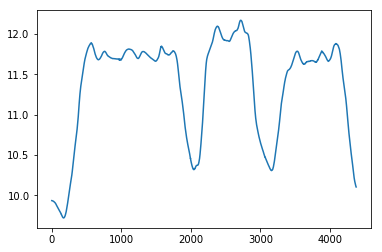

In [18]:
plt.plot(dists[0])